In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import os

csv_file = '../30movies_dataset.csv'
df = pd.read_csv(csv_file)

print(f"\nDataset loaded from: {csv_file}")
print(f"Total records: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())


Dataset loaded from: ../30movies_dataset.csv
Total records: 30

Columns: ['Title', 'Year', 'Genre', 'Director', 'Lead Actor', 'Production Company', 'Runtime (min)', 'Country of Origin', 'Original Language', 'Gross Revenue (million)', 'Success']

First few rows:
                      Title  Year                  Genre         Director  \
0  The Grand Budapest Hotel  2014           Comedy-Drama     Wes Anderson   
1                  Parasite  2019  Thriller, Dark Comedy     Bong Joon-ho   
2                      1917  2019             War, Drama       Sam Mendes   
3        Mad Max: Fury Road  2015         Action, Sci-Fi    George Miller   
4                La La Land  2016       Musical, Romance  Damien Chazelle   

      Lead Actor        Production Company  Runtime (min) Country of Origin  \
0  Ralph Fiennes  Fox Searchlight Pictures             99     USA / Germany   
1   Song Kang-ho          CJ Entertainment            132       South Korea   
2  George MacKay       DreamWorks Pic

In [2]:
# features and target variables
categorical_columns = ['Genre', 'Director', 'Lead Actor', 'Production Company', 
                       'Country of Origin', 'Original Language']

feature_columns_base = ['Year', 'Runtime (min)'] + categorical_columns
X_base = df[feature_columns_base].copy()
y = df['Gross Revenue (million)'].values

print(f"\nFeature columns: {feature_columns_base}")
print(f"Target variable: Gross Revenue (million)")
print(f"\nFeature matrix shape: {X_base.shape}")
print(f"Target vector shape: {y.shape}")



Feature columns: ['Year', 'Runtime (min)', 'Genre', 'Director', 'Lead Actor', 'Production Company', 'Country of Origin', 'Original Language']
Target variable: Gross Revenue (million)

Feature matrix shape: (30, 8)
Target vector shape: (30,)


In [5]:
# train and test
X_train_base, X_test_base, y_train, y_test, train_idx, test_idx = train_test_split(
    X_base, y, df.index, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_base)} ({len(X_train_base)/len(X_base)*100:.1f}%)")
print(f"Testing samples: {len(X_test_base)} ({len(X_test_base)/len(X_base)*100:.1f}%)")


mean_revenue = y_train.mean()
print(f"\nMean Revenue Threshold (from training data only): ${mean_revenue:,.2f}")



Training samples: 24 (80.0%)
Testing samples: 6 (20.0%)

Mean Revenue Threshold (from training data only): $437.85


In [6]:
label_encoders = {}
X_train_encoded = pd.DataFrame()
X_test_encoded = pd.DataFrame()

# numerical features
X_train_encoded['Year'] = X_train_base['Year'].values
X_train_encoded['Runtime (min)'] = X_train_base['Runtime (min)'].values
X_test_encoded['Year'] = X_test_base['Year'].values
X_test_encoded['Runtime (min)'] = X_test_base['Runtime (min)'].values

# categorical features
for col in categorical_columns:
    le = LabelEncoder()
    X_train_encoded[f'{col}_encoded'] = le.fit_transform(X_train_base[col].astype(str))
    
    # handling unseen categories in test set
    test_values = X_test_base[col].astype(str).values
    encoded_test = []
    for val in test_values:
        if val in le.classes_:
            encoded_test.append(le.transform([val])[0])
        else:
            encoded_test.append(0)
    
    X_test_encoded[f'{col}_encoded'] = encoded_test
    label_encoders[col] = le
    
    print(f"{col}: {len(le.classes_)} unique values")

print("\nEncoding completed!")

Genre: 21 unique values
Director: 22 unique values
Lead Actor: 21 unique values
Production Company: 18 unique values
Country of Origin: 11 unique values
Original Language: 3 unique values

Encoding completed!


In [ ]:
train_df = X_train_encoded.copy()
train_df['revenue'] = y_train
train_df['Director_encoded'] = X_train_encoded['Director_encoded']
train_df['Year'] = X_train_encoded['Year']
# sort by director and year so averages grow over time
train_df = train_df.sort_values(by=['Director_encoded', 'Year']).reset_index(drop=True)
# computing average revenue for each director
train_df['director_avg_revenue'] = (
    train_df.groupby('Director_encoded')['revenue']
    .transform(lambda x: x.expanding().mean())
)

director_stats = train_df.groupby('Director_encoded')['revenue'].mean().to_dict()

X_test_encoded['director_avg_revenue'] = X_test_encoded['Director_encoded'].map(director_stats).fillna(mean_revenue)
X_train_encoded['director_avg_revenue'] = train_df['director_avg_revenue'].values

print("Director average revenue feature created!")
print(f"Unique directors in training: {len(director_stats)}")

# final feature set
feature_columns = ['Year', 'Runtime (min)', 'Genre_encoded', 'Director_encoded', 
                   'Lead Actor_encoded', 'Production Company_encoded', 
                   'Country of Origin_encoded', 'Original Language_encoded', 
                   'director_avg_revenue']

X_train = X_train_encoded[feature_columns].values
X_test = X_test_encoded[feature_columns].values


print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Feature names: {feature_columns}")

Director average revenue feature created!
Unique directors in training: 22
Training features shape: (24, 9)
Testing features shape: (6, 9)
Feature names: ['Year', 'Runtime (min)', 'Genre_encoded', 'Director_encoded', 'Lead Actor_encoded', 'Production Company_encoded', 'Country of Origin_encoded', 'Original Language_encoded', 'director_avg_revenue']


In [9]:
linear_svr_model = LinearSVR(C=1.0, epsilon=0.5, max_iter=5000, random_state=42)
linear_svr_model.fit(X_train, y_train)

print("Model training completed!")
print(f"Model parameters:")
print(f"  C (regularization): 1.0")
print(f"  Epsilon (tolerance): 0.5")
print(f"  Max iterations: 5000")

# predict on test set (no negative revenues allowed)
y_pred_test = linear_svr_model.predict(X_test)
y_pred_test = np.maximum(0, y_pred_test)  
print(f"Number of predictions: {len(y_pred_test)}")
print(f"Prediction range: ${y_pred_test.min():,.2f} to ${y_pred_test.max():,.2f}")

# test dataframe with predictions
df_test = X_test_encoded.copy()
df_test['predicted_revenue'] = y_pred_test
df_test['actual_revenue'] = y_test

for col in categorical_columns:
    encoded_col = f'{col}_encoded'
    df_test[col] = df_test[encoded_col].apply(
        lambda x: label_encoders[col].classes_[int(x)] if int(x) < len(label_encoders[col].classes_) else 'Unknown'
    )

print("\nCategorical features decoded successfully!")

Model training completed!
Model parameters:
  C (regularization): 1.0
  Epsilon (tolerance): 0.5
  Max iterations: 5000
Number of predictions: 6
Prediction range: $238.95 to $483.03

Categorical features decoded successfully!


c:\Users\Dell\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:

# converting actual and predicted revenue to binary success/failure 
df_test['predicted_success'] = (df_test['predicted_revenue'] >= mean_revenue).astype(int)
df_test['actual_success'] = (df_test['actual_revenue'] >= mean_revenue).astype(int)

print(f"Mean revenue threshold: ${mean_revenue:,.2f}")
print(f"Predicted successes: {df_test['predicted_success'].sum()}")
print(f"Actual successes: {df_test['actual_success'].sum()}")


output_columns = ['Year', 'Genre', 'Director', 'Lead Actor', 'Production Company', 
                  'Country of Origin', 'Original Language', 'Runtime (min)',
                  'predicted_revenue', 'actual_revenue', 
                  'predicted_success', 'actual_success']

df_output = df_test[output_columns].copy()
df_output = df_output.sort_values(by=['Year', 'Director']).drop_duplicates()
df_output.to_csv('movie_revenue_predictions.csv', index=False)

print("\nModel Training Complete!")
print(f"Predicted and Actual Revenue with Success Labels saved to 'movie_revenue_predictions.csv'")
print("\nSample predictions:")
print(df_output.head(10))


print(f"Total movies in test set: {len(df_test)}")
print(f"Predicted successes: {df_test['predicted_success'].sum()}")
print(f"Actual successes: {df_test['actual_success'].sum()}")
print(f"Correct predictions: {(df_test['predicted_success'] == df_test['actual_success']).sum()}")
print(f"Test accuracy: {(df_test['predicted_success'] == df_test['actual_success']).mean():.2%}")


csv_file = "movie_revenue_predictions.csv"
df = pd.read_csv(csv_file)
df["predicted_revenue"] = df["predicted_revenue"].apply(lambda x: int(x))

print(f"Loaded predictions from: {csv_file}")
print(f"Total movies for analysis: {len(df)}")

# computing classification metrics for success prediction
precision = precision_score(df["actual_success"], df["predicted_success"], zero_division=0)
recall = recall_score(df["actual_success"], df["predicted_success"], zero_division=0)
f1 = f1_score(df["actual_success"], df["predicted_success"], zero_division=0)
accuracy = accuracy_score(df["actual_success"], df["predicted_success"])


print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")


Mean revenue threshold: $437.85
Predicted successes: 1
Actual successes: 1

Model Training Complete!
Predicted and Actual Revenue with Success Labels saved to 'movie_revenue_predictions.csv'

Sample predictions:
   Year      Genre               Director Lead Actor     Production Company  \
1  2012     Action      Christopher Nolan  Amy Adams  Warner Bros. Pictures   
0  2014  Biography  Alejandro G. Iñárritu  Amy Adams       20th Century Fox   
3  2014     Action        Damien Chazelle  Amy Adams  Blumhouse Productions   
5  2017     Action  Alejandro G. Iñárritu  Amy Adams       20th Century Fox   
2  2018     Action  Alejandro G. Iñárritu  Amy Adams       20th Century Fox   
4  2021     Action       Denis Villeneuve  Amy Adams     Legendary Pictures   

  Country of Origin Original Language  Runtime (min)  predicted_revenue  \
1          USA / UK           English            164         483.026777   
0                UK           English            118         260.986602   
3        

MAE (Mean Absolute Error): $203.33
MSE (Mean Squared Error): $79,683.41
RMSE (Root Mean Squared Error): $282.28


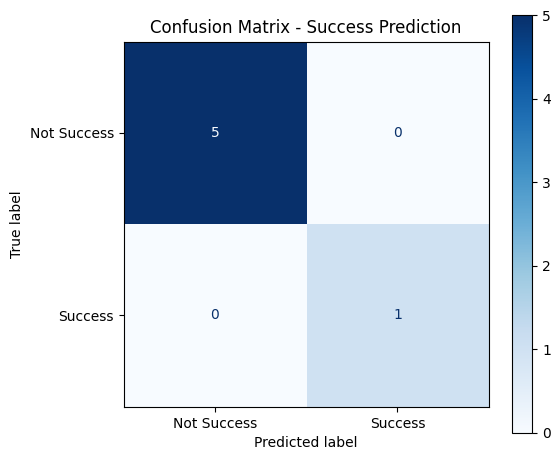

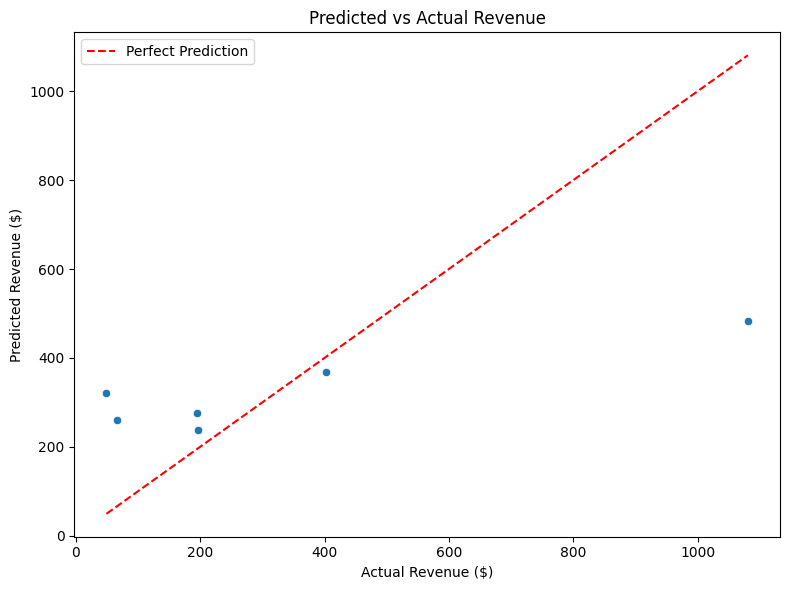

In [11]:
# --- regression metrics ---
mae = mean_absolute_error(df["actual_revenue"], df["predicted_revenue"])
mse = mean_squared_error(df["actual_revenue"], df["predicted_revenue"])
rmse = np.sqrt(mse)

print(f"MAE (Mean Absolute Error): ${mae:,.2f}")
print(f"MSE (Mean Squared Error): ${mse:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")

cm = confusion_matrix(df["actual_success"], df["predicted_success"])
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(cm, display_labels=["Not Success", "Success"]).plot(cmap="Blues", ax=ax)
plt.title("Confusion Matrix - Success Prediction")
plt.tight_layout()
plt.show() 

# --- scatter plot: predicted vs actual revenue ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x="actual_revenue", y="predicted_revenue", data=df)
plt.plot([df["actual_revenue"].min(), df["actual_revenue"].max()],
         [df["actual_revenue"].min(), df["actual_revenue"].max()],
         color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Revenue ($)")
plt.ylabel("Predicted Revenue ($)")
plt.title("Predicted vs Actual Revenue")
plt.legend()
plt.tight_layout()
plt.show()  


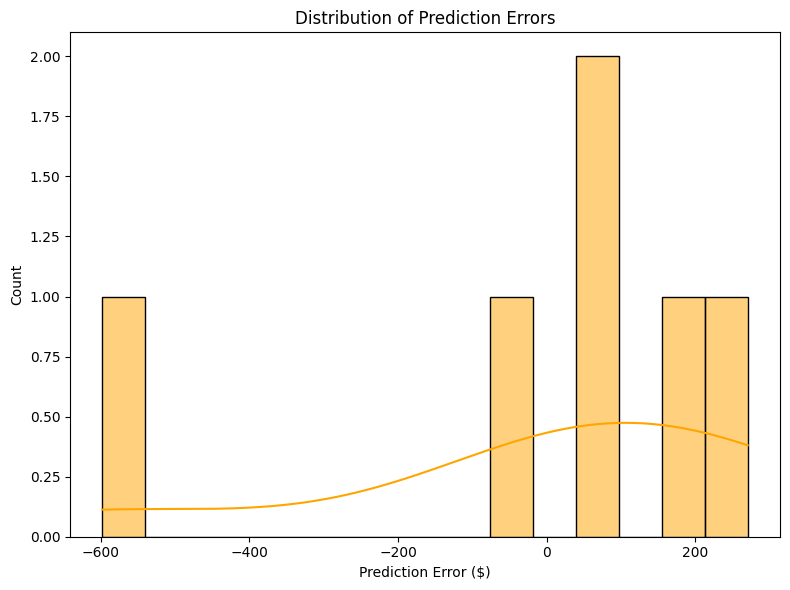

C:\Users\Dell\AppData\Local\Temp\ipykernel_13412\2429309801.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Genre", y="mae_per_genre", data=genre_stats, palette="viridis")


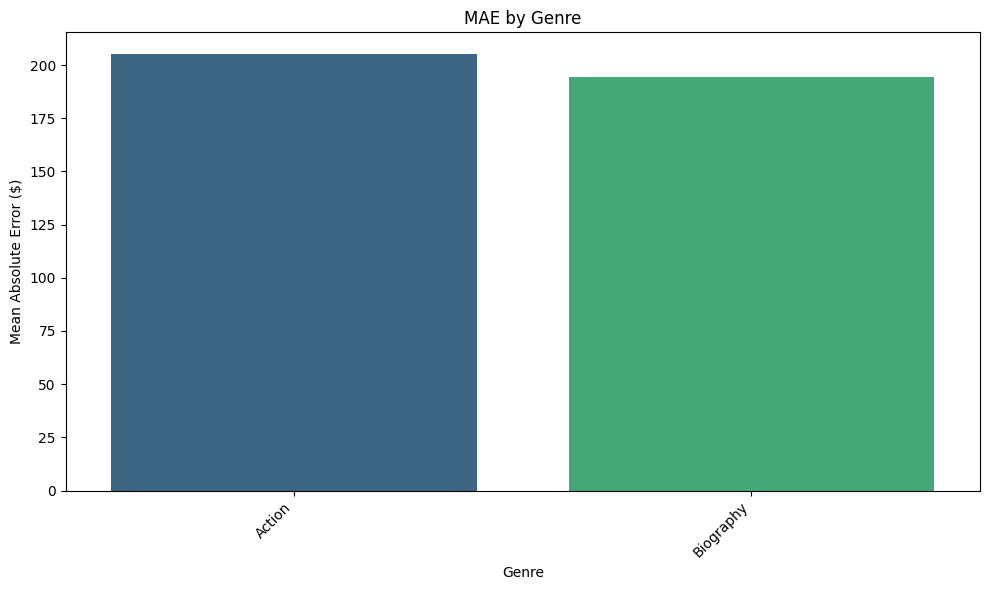

C:\Users\Dell\AppData\Local\Temp\ipykernel_13412\2429309801.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Genre", y="mse_per_genre", data=genre_stats, palette="magma")


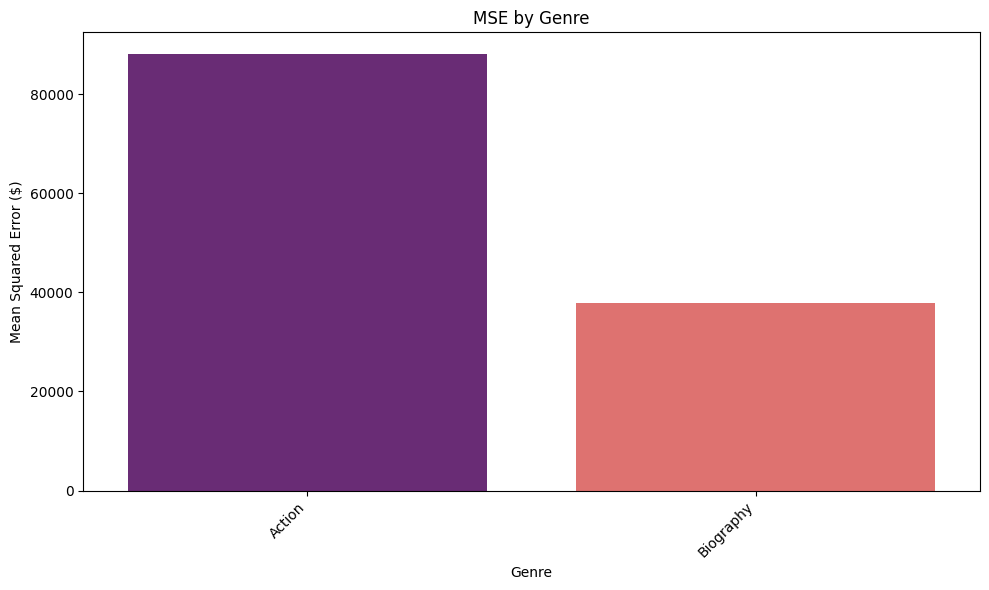

In [15]:
# ppredicting error, MAE, MSE
df["error"] = df["predicted_revenue"] - df["actual_revenue"]
plt.figure(figsize=(8, 6))
sns.histplot(df["error"], bins=15, kde=True, color="orange")
plt.xlabel("Prediction Error ($)")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()


genre_stats = df.groupby("Genre").agg(
    mae_per_genre=("error", lambda x: np.mean(np.abs(x))),
    mse_per_genre=("error", lambda x: np.mean(x**2)),
    movie_count=("Genre", "count")
).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x="Genre", y="mae_per_genre", data=genre_stats, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Absolute Error ($)")
plt.title("MAE by Genre")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x="Genre", y="mse_per_genre", data=genre_stats, palette="magma")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Squared Error ($)")
plt.title("MSE by Genre")
plt.tight_layout()
plt.show()


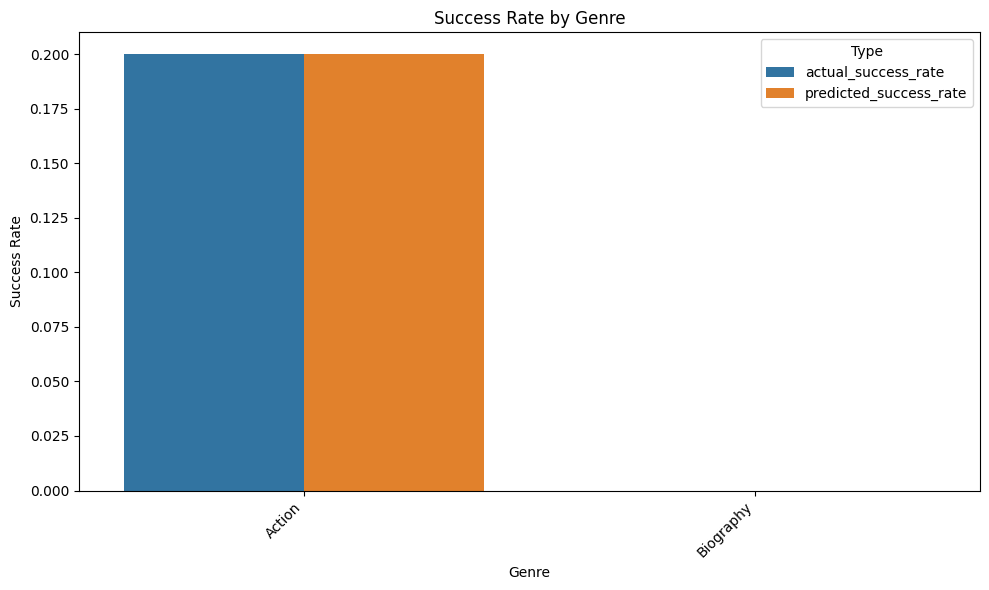

Total movies analyzed: 6
Number of genres: 2


In [16]:
#success Rate by Genre
genre_success = df.groupby("Genre").agg(
    actual_success_rate=("actual_success", "mean"),
    predicted_success_rate=("predicted_success", "mean"),
    movie_count=("Genre", "count")
).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_success.melt(id_vars="Genre",
                            value_vars=["actual_success_rate", "predicted_success_rate"],
                            var_name="Type", value_name="Success Rate"),
    x="Genre", y="Success Rate", hue="Type"
)
plt.xticks(rotation=45, ha="right")
plt.title("Success Rate by Genre")
plt.tight_layout()
plt.show()

print(f"Total movies analyzed: {len(df)}")
print(f"Number of genres: {len(genre_stats)}")
